## TP 2 - Computer Vision

In [846]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [847]:
img = cv.imread(r'C:\Users\Leandro\Desktop\Inteligencia Artificial\3er Bimestre\Computer Vision\circlesOut.jpg', cv.IMREAD_GRAYSCALE)
cheems = cv.imread(r'C:\Users\Leandro\Desktop\cheems.png', cv.IMREAD_GRAYSCALE)

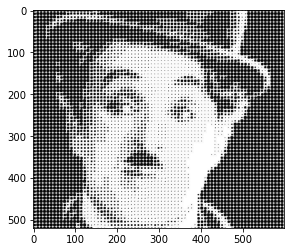

In [848]:
plt.imshow(img, cmap = 'gray')
plt.show()

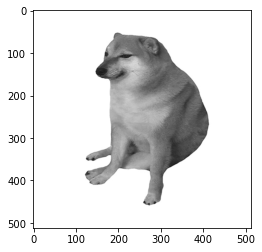

In [849]:
plt.imshow(cheems, cmap = 'gray')
plt.show()

### Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.

In [850]:
def create_gauss_filter(h, w, k_size, sigma):
    k = np.linspace(-(k_size - 1) / 2., (k_size - 1) / 2., k_size)
    mat = np.array([])
    gauss = np.exp(-0.5 * np.square(k) / np.square(sigma))
    mat = np.outer(gauss, gauss)
    kernel = mat / np.sum(mat)
    
    up = (h - k_size) // 2 
    down = h - up - k_size
    left = (w - k_size) // 2 
    right = w - left - k_size 
    full_kernel = np.pad(kernel, ((up, down),(left, right)), "constant", constant_values = (0,0))
        
    return full_kernel, np.fft.fft2(full_kernel)

#### 1) Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro en una imagen para validar el funcionamiento en el dominio espectral.

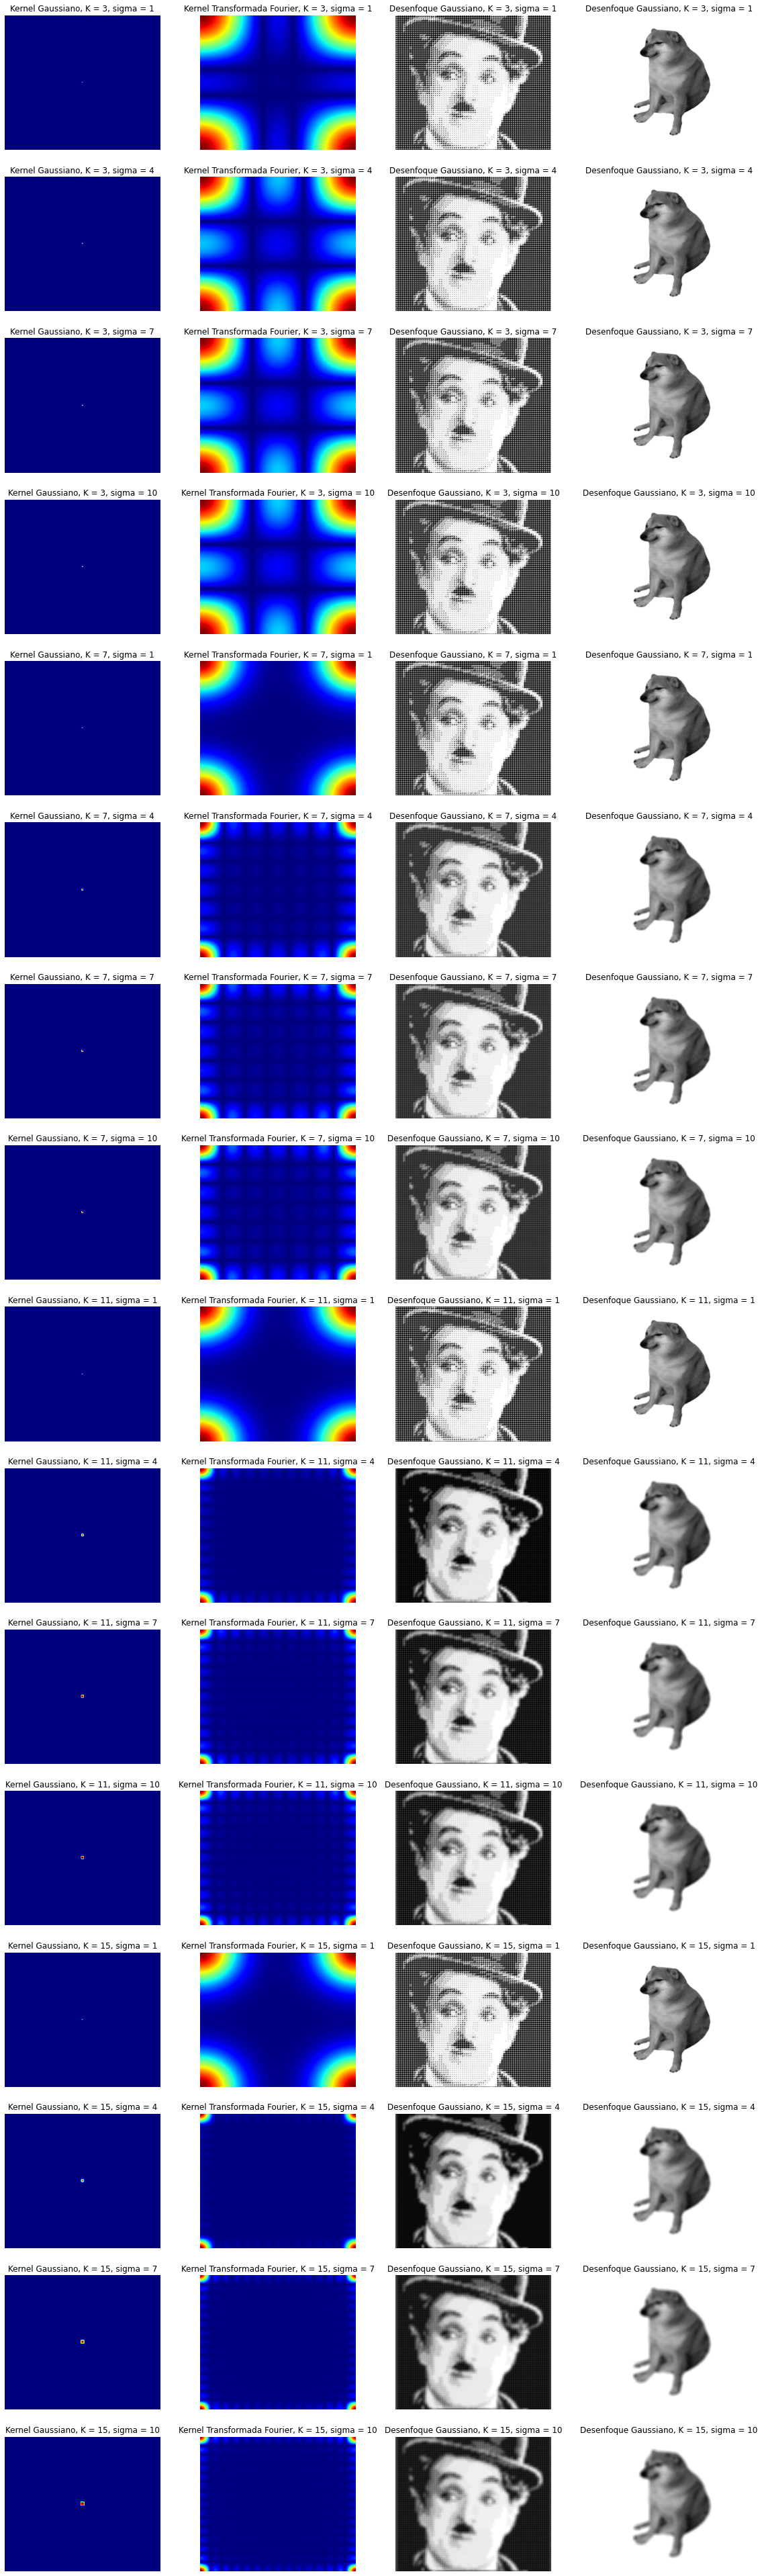

In [851]:
# Muestro imágenes con diferentes tamaños de kernel y desvíos.
ks = np.arange(3, 19, 4)
sigmas = np.arange(1, 11, 3)

fig, axs = plt.subplots(len(ks) * len(sigmas), 4, figsize = (20,70))
for i in range(len(ks)):
    for j in range(len(sigmas)):
        kernel_gauss, kernel_fourier = create_gauss_filter(img.shape[0], img.shape[1], ks[i], sigmas[j])
        kernel_gauss_cheems, kernel_fourier_cheems = create_gauss_filter(cheems.shape[0], cheems.shape[1], ks[i], sigmas[j])
        
        img_fft = np.fft.fft2(img)
        filtered = img_fft * kernel_fourier    
        img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))
        
        img_fft_cheems = np.fft.fft2(cheems)
        filtered_cheems = img_fft_cheems * kernel_fourier_cheems  
        img_gauss_cheems = np.fft.ifftshift(np.real(np.fft.ifft2(filtered_cheems)))
        
        text = K = 'K = ' + str(ks[i]) + ', sigma = ' + str(sigmas[j])
        
        axs[i * len(sigmas) + j,0].imshow(kernel_gauss, cmap = 'jet')
        axs[i * len(sigmas) + j,0].set_title('Kernel Gaussiano, ' + text)
        axs[i * len(sigmas) + j,0].axis('off')
        axs[i * len(sigmas) + j,1].imshow(np.abs(kernel_fourier), cmap = 'jet')
        axs[i * len(sigmas) + j,1].set_title('Kernel Transformada Fourier, ' + text)
        axs[i * len(sigmas) + j,1].axis('off')
        axs[i * len(sigmas) + j,2].imshow(img_gauss, cmap = 'gray')
        axs[i * len(sigmas) + j,2].set_title('Desenfoque Gaussiano, ' + text)
        axs[i * len(sigmas) + j,2].axis('off')
        axs[i * len(sigmas) + j,3].imshow(img_gauss_cheems, cmap = 'gray')
        axs[i * len(sigmas) + j,3].set_title('Desenfoque Gaussiano, ' + text)
        axs[i * len(sigmas) + j,3].axis('off')

plt.show()

La imagen anterior muestra le kernel gaussiano y el de fourier para la imagen de Chaplin; y se agregó una imagen más de un perro para mayor comparación. Se puede ver cómo los mayores desenfoque se corresponden con mayores valores de sigma. Pero para lograr una buena imagen, hay que negociar con los valores de K y Sigma en una especia de 'tradeoff', porque a mayores valores de K y de sigma en simultáneo, se sigue percibiendo el efecto cuadriculado de la imagen. Parecería que la mejor combinación sería un K y sigma moderados.

#### 2) Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

In [852]:
# Creo función para determinar la calidad de imagen.
def ImageQuality(img):
    # 1) Compute F which is the Fourier Transform representation of image I.
    F = np.fft.fft2(img)
    # 2) Find Fc which is obtained by shifting the origin of F to centre.
    Fc = np.fft.fftshift(np.real(F))
    # 3) Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I.
    AF = abs(Fc)
    # 4) Calculate M = max (AF) where M is the maximum value of the frequency component in F.
    M = np.max(AF)
    # 5) Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000.
    threshold = M / 1000
    v = F.flatten()
    Th = sum(1 for x in range(len(v)) if v[x] > threshold)
    # 6) Calculate Image Quality measure (FM) from equation (1).
    IMQ = Th / (img.shape[0] * img.shape[1])    
    return IMQ

In [853]:
# A modo de ejemplo, calculo la calidad de imagen para el K = 15 y Sigma = 3.
kernel_gauss, kernel_fourier = create_gauss_filter(img.shape[0], img.shape[1], 15, 3)
kernel_gauss_cheems, kernel_fourier_cheems = create_gauss_filter(cheems.shape[0], cheems.shape[1], 15, 3)

img_conv = cv.GaussianBlur(img, ksize = (15, 15), sigmaX = 3)
img_conv_cheems = cv.GaussianBlur(cheems, ksize = (15, 15), sigmaX = 3)

img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_fourier    
img_fourier = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

img_fft_cheems = np.fft.fft2(cheems)
filtered_cheems = img_fft_cheems * kernel_fourier_cheems    
img_fourier_cheems = np.fft.ifftshift(np.real(np.fft.ifft2(filtered_cheems)))

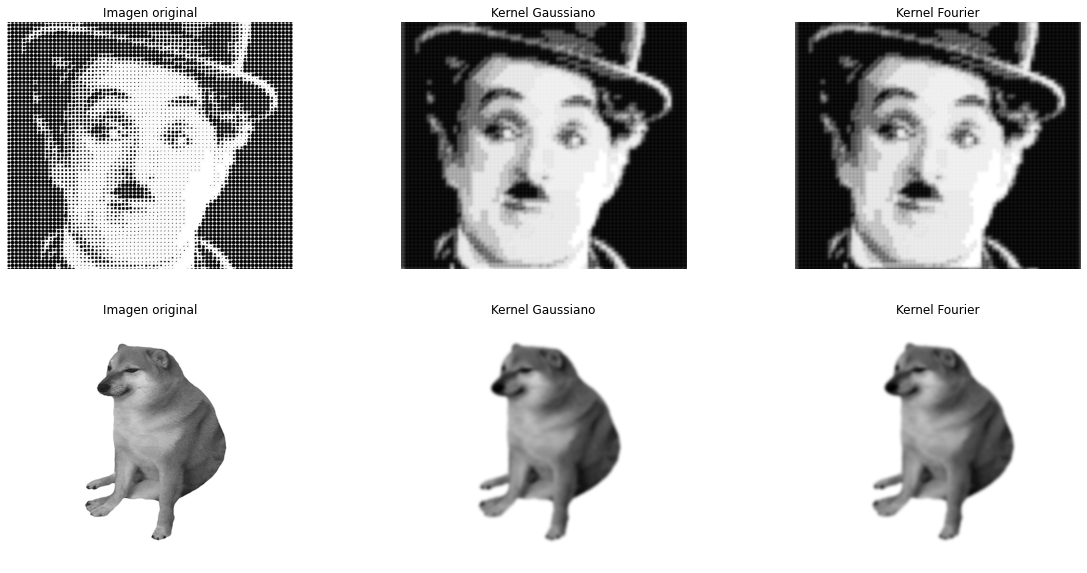

In [854]:
# Muestro los ejemplos. 
fig, axs = plt.subplots(2,3, figsize = (20,10))       

axs[0,0].imshow(img, cmap = 'gray')
axs[0,0].set_title('Imagen original')
axs[0,0].axis('off')
axs[0,1].imshow(img_conv, cmap = 'gray')
axs[0,1].set_title('Kernel Gaussiano')
axs[0,1].axis('off')
axs[0,2].imshow(img_fourier, cmap = 'gray')
axs[0,2].set_title('Kernel Fourier')
axs[0,2].axis('off')
axs[1,0].imshow(cheems, cmap = 'gray')
axs[1,0].set_title('Imagen original')
axs[1,0].axis('off')
axs[1,1].imshow(img_conv_cheems, cmap = 'gray')
axs[1,1].set_title('Kernel Gaussiano')
axs[1,1].axis('off')
axs[1,2].imshow(img_fourier_cheems, cmap = 'gray')
axs[1,2].set_title('Kernel Fourier')
axs[1,2].axis('off')

plt.show()

In [855]:
# Ahora calculo la calidad de imagen para todas las combinaciones de Ks y Sigmas mostradas anteriormente.
ks = np.arange(3, 19, 4)
sigmas = np.arange(1, 11, 3)

chaplin_conv = np.array([])
chaplin_fourier = np.array([])
cheems_conv = np.array([])
cheems_fourier = np.array([])
row_names = np.array([])
K = np.array([])
S = np.array([])

for i in range(len(sigmas)):
    for j in range(len(ks)):
        kernel_gauss, kernel_fourier = create_gauss_filter(img.shape[0], img.shape[1], ks[j], sigmas[i])
        kernel_gauss_cheems, kernel_fourier_cheems = create_gauss_filter(cheems.shape[0], cheems.shape[1], ks[j], sigmas[i])
        
        row_name = 'K = ' + str(ks[j]) + ', sigma = ' + str(sigmas[i])
        row_names = np.append(row_names, [row_name])
        
        # Chaplin.
        img_conv = cv.GaussianBlur(img, ksize = (ks[j], ks[j]), sigmaX = sigmas[i])
        img_fft = np.fft.fft2(img)
        filtered = img_fft * kernel_fourier    
        img_fourier = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))
        
        # Perro Cheems.
        img_conv_cheems = cv.GaussianBlur(cheems, ksize = (ks[j], ks[j]), sigmaX = sigmas[i])
        img_fft_cheems = np.fft.fft2(cheems)
        filtered_cheems = img_fft_cheems * kernel_fourier_cheems    
        img_fourier_cheems = np.fft.ifftshift(np.real(np.fft.ifft2(filtered_cheems)))
        
        chaplin_conv = np.append(chaplin_conv, [ImageQuality(img_conv)])
        chaplin_fourier = np.append(chaplin_fourier, [ImageQuality(img_fourier)])
        cheems_conv = np.append(cheems_conv, [ImageQuality(img_conv_cheems)])
        cheems_fourier = np.append(cheems_fourier, [ImageQuality(img_fourier_cheems)])
        K = np.append(K, [ks[j]])
        S = np.append(S, [sigmas[i]])


dif_Chaplin =  abs(chaplin_conv - chaplin_fourier)/chaplin_conv
dif_Cheems =  abs(cheems_conv - cheems_fourier)/cheems_conv
df = pd.DataFrame({'K': K,
                   'Sigma': S,
                   'Chaplin_C': chaplin_conv,
                   'Chaplin_F': chaplin_fourier,
                   'Chaplin_Diff': dif_Chaplin,
                   'Cheems_C': cheems_conv,
                   'Cheems_F': cheems_fourier,
                   'Cheems_Diff': dif_Cheems})

In [869]:
# Muestro el dataframe comparando las puntuaciones de cada combinación. 
# La columna DIFF muestra la diferencia porcentual entre la convolución y la fourier.
df

,K,Sigma,Chaplin_C,Chaplin_F,Chaplin_Diff,Cheems_C,Cheems_F,Cheems_Diff
0,3.0,1.0,1.558894e+09,1.562849e+09,0.002537,21351680.0,2.131252e+07,0.001834
1,7.0,1.0,1.064943e+09,1.071181e+09,0.005857,17264758.0,1.724704e+07,0.001027
2,11.0,1.0,1.064943e+09,1.069835e+09,0.004594,17264758.0,1.723356e+07,0.001807
3,15.0,1.0,1.064943e+09,1.069835e+09,0.004594,17264758.0,1.723356e+07,0.001807
4,3.0,4.0,1.356945e+09,1.356948e+09,0.000003,19668492.0,1.961410e+07,0.002765
5,7.0,4.0,1.022747e+08,1.022806e+08,0.000058,8936428.0,8.903581e+06,0.003676
6,11.0,4.0,2.064842e+07,2.127760e+07,0.030471,5995304.0,5.994193e+06,0.000185
7,15.0,4.0,9.982296e+06,1.146239e+07,0.148271,4880428.0,4.874571e+06,0.001200
8,3.0,7.0,1.345526e+09,1.349883e+09,0.003238,19566698.0,1.955030e+07,0.000838
9,7.0,7.0,7.728612e+07,7.981115e+07,0.032671,8632322.0,8.625813e+06,0.000754


C:\Users\Leandro\AppData\Local\Temp/ipykernel_22184/1522027445.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(row_names)


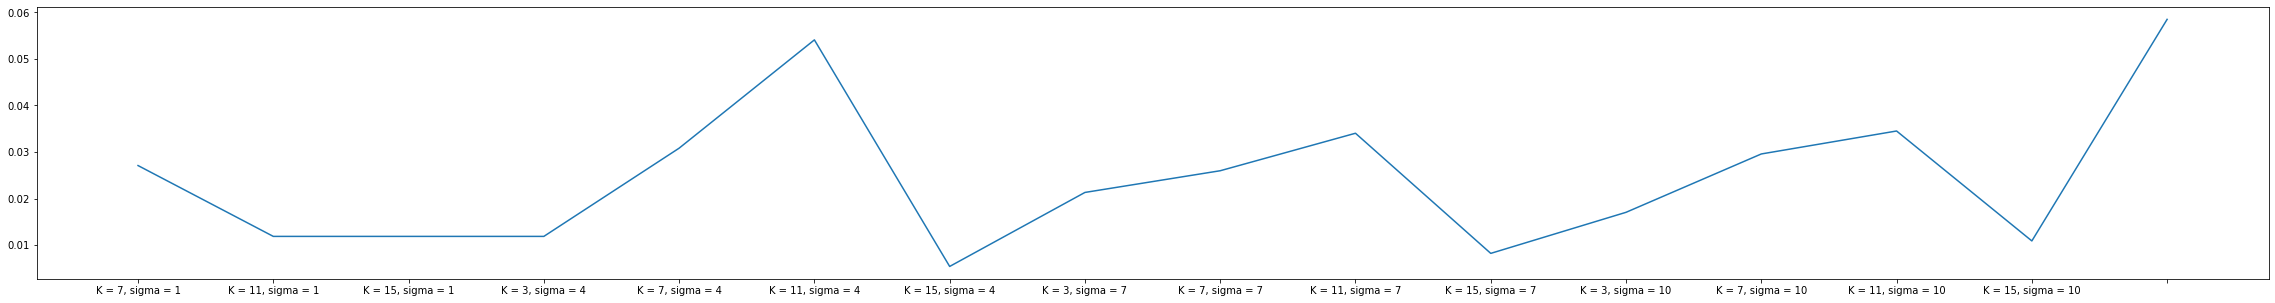

In [857]:
# Muestro las diferencias en la imagen de Chaplin.
fig = plt.figure(figsize = (40,5))
ax = fig.subplots()

ax.plot(df['Chaplin_Diff'])
ax.set_xticklabels(row_names)
plt.locator_params(axis = 'x', nbins = 30)
plt.show()

C:\Users\Leandro\AppData\Local\Temp/ipykernel_22184/294649494.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(row_names)


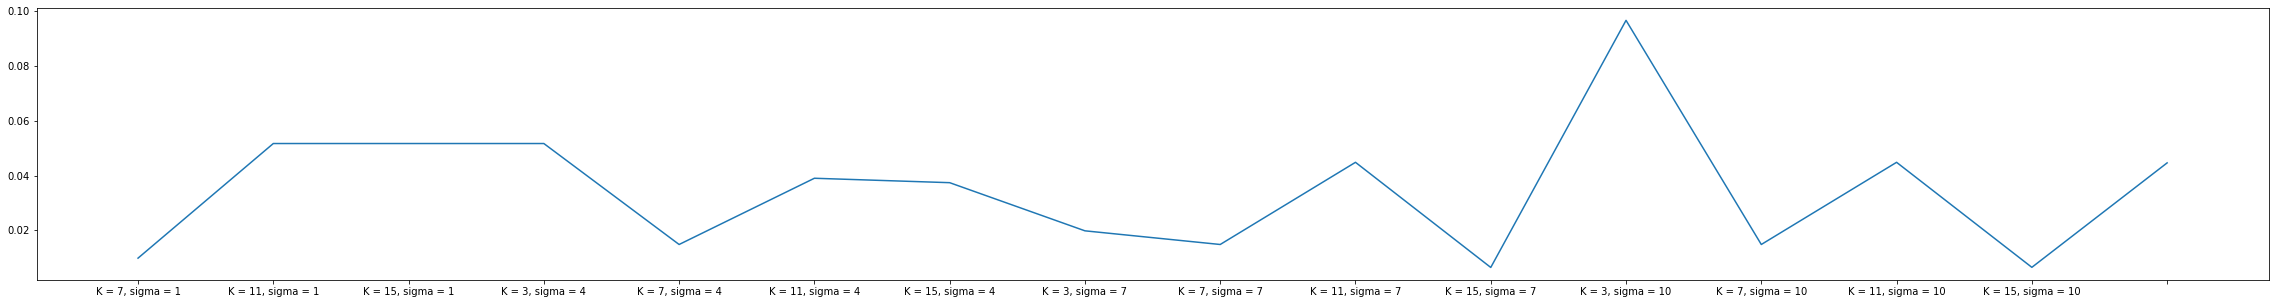

In [858]:
# Muestro las diferencias en la imagen del perro Cheems
fig = plt.figure(figsize = (40,5))
ax = fig.subplots()

ax.plot(df['Cheems_Diff'])
ax.set_xticklabels(row_names)
plt.locator_params(axis = 'x', nbins = 30)
plt.show()

Podemos notar que las diferencias entre las imágenes con filtros convolucionales y fourier (para las mismas configuraciones de K y Sigma) son muy chicas. En los gráficos mostrados arriba, se puede apreciar cómo las mayores diferencias están para los K = 7 en la iamgen de Chaplin.

#### 3) Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape-from-focus”

A continuación, vamos a definir las funciones para calcular las métricas con 2 métodos diferentes.

In [859]:
# Creo función para Absolute central moment.
def ACMo(img):
    M = img.flatten().astype(int)
    mu = np.mean(M)
    unique, counts = np.unique(M, return_counts = True)
    count_dic = dict(zip(unique, counts))
    L = len(count_dic)
    r = 0
    
    for i in count_dic.keys():
        pk = count_dic[i] / len(M)
        r = r + np.abs(count_dic[i] - mu) * pk
    
    return r

In [860]:
# Creo función para Brenner’s focus measure.
def Brenner(img):
    img = img.astype(float)
    dim1 = img.shape[0]
    dim2 = img.shape[1]
    
    r = 0
    
    for i in range(dim1 - 2):
        for j in range(dim2):
            r = r + np.abs(img[i, j] - img[i + 2, j])**2
    
    return r

In [861]:
# Ahora calculo la calidad de imagen para todas las combinaciones de Ks y Sigmas mostradas anteriormente.
ks = np.arange(3, 19, 4)
sigmas = np.arange(1, 11, 3)

chaplin_conv = np.array([])
chaplin_fourier = np.array([])
cheems_conv = np.array([])
cheems_fourier = np.array([])
row_names = np.array([])
K = np.array([])
S = np.array([])

for i in range(len(sigmas)):
    for j in range(len(ks)):
        kernel_gauss, kernel_fourier = create_gauss_filter(img.shape[0], img.shape[1], ks[j], sigmas[i])
        kernel_gauss_cheems, kernel_fourier_cheems = create_gauss_filter(cheems.shape[0], cheems.shape[1], ks[j], sigmas[i])
        
        row_name = 'K = ' + str(ks[j]) + ', sigma = ' + str(sigmas[i])
        row_names = np.append(row_names, [row_name])
        
        # Chaplin.
        img_conv = cv.GaussianBlur(img, ksize = (ks[j], ks[j]), sigmaX = sigmas[i])
        img_fft = np.fft.fft2(img)
        filtered = img_fft * kernel_fourier    
        img_fourier = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))
        
        # Perro Cheems.
        img_conv_cheems = cv.GaussianBlur(cheems, ksize = (ks[j], ks[j]), sigmaX = sigmas[i])
        img_fft_cheems = np.fft.fft2(cheems)
        filtered_cheems = img_fft_cheems * kernel_fourier_cheems    
        img_fourier_cheems = np.fft.ifftshift(np.real(np.fft.ifft2(filtered_cheems)))
        
        chaplin_conv = np.append(chaplin_conv, [ACMo(img_conv)])
        chaplin_fourier = np.append(chaplin_fourier, [ACMo(img_fourier)])
        cheems_conv = np.append(cheems_conv, [ACMo(img_conv_cheems)])
        cheems_fourier = np.append(cheems_fourier, [ACMo(img_fourier_cheems)])
        K = np.append(K, [ks[j]])
        S = np.append(S, [sigmas[i]])


dif_Chaplin =  abs(chaplin_conv - chaplin_fourier)/chaplin_conv
dif_Cheems =  abs(cheems_conv - cheems_fourier)/cheems_conv
df = pd.DataFrame({'K': K,
                   'Sigma': S,
                   'Chaplin_C': chaplin_conv,
                   'Chaplin_F': chaplin_fourier,
                   'Chaplin_Diff': dif_Chaplin,
                   'Cheems_C': cheems_conv,
                   'Cheems_F': cheems_fourier,
                   'Cheems_Diff': dif_Cheems})

In [862]:
df

,K,Sigma,Chaplin_C,Chaplin_F,Chaplin_Diff,Cheems_C,Cheems_F,Cheems_Diff
0,3.0,1.0,6972.675434,6967.200046,0.000785,135349.334368,122879.008393,0.092134
1,7.0,1.0,3840.646685,3824.357642,0.004241,134831.876592,78314.884795,0.419166
2,11.0,1.0,3840.646685,3844.578595,0.001024,134831.876592,119456.107095,0.114037
3,15.0,1.0,3840.646685,3871.255437,0.007970,134831.876592,123052.939368,0.087360
4,3.0,4.0,8119.362738,8261.536227,0.017510,135363.116804,83640.312333,0.382104
5,7.0,4.0,3655.763053,3861.495125,0.056276,134109.759678,81422.376076,0.392868
6,11.0,4.0,5774.798513,6285.399844,0.088419,132127.618533,77173.350276,0.415918
7,15.0,4.0,7252.417730,7992.720530,0.102077,129168.512030,78366.187443,0.393303
8,3.0,7.0,8227.115004,8326.584511,0.012090,135363.132494,85022.345615,0.371894
9,7.0,7.0,4378.108271,4554.236723,0.040229,134063.899333,81743.788054,0.390262


C:\Users\Leandro\AppData\Local\Temp/ipykernel_22184/1522027445.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(row_names)


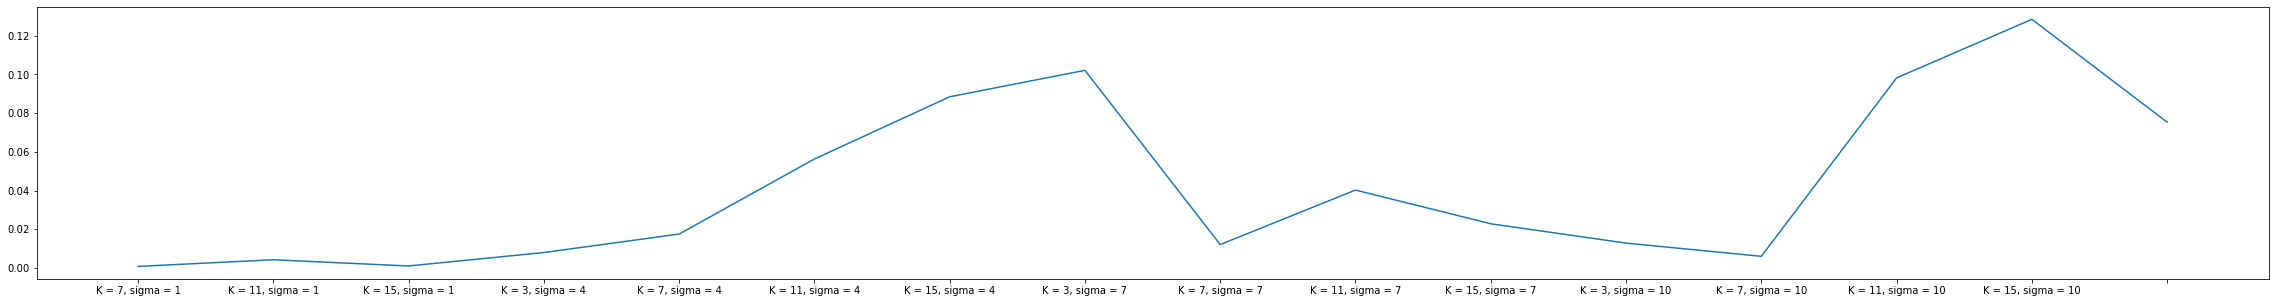

In [863]:
# Muestro las diferencias en la imagen de Chaplin.
fig = plt.figure(figsize = (40,5))
ax = fig.subplots()

ax.plot(df['Chaplin_Diff'])
ax.set_xticklabels(row_names)
plt.locator_params(axis = 'x', nbins = 30)
plt.show()

C:\Users\Leandro\AppData\Local\Temp/ipykernel_22184/294649494.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(row_names)


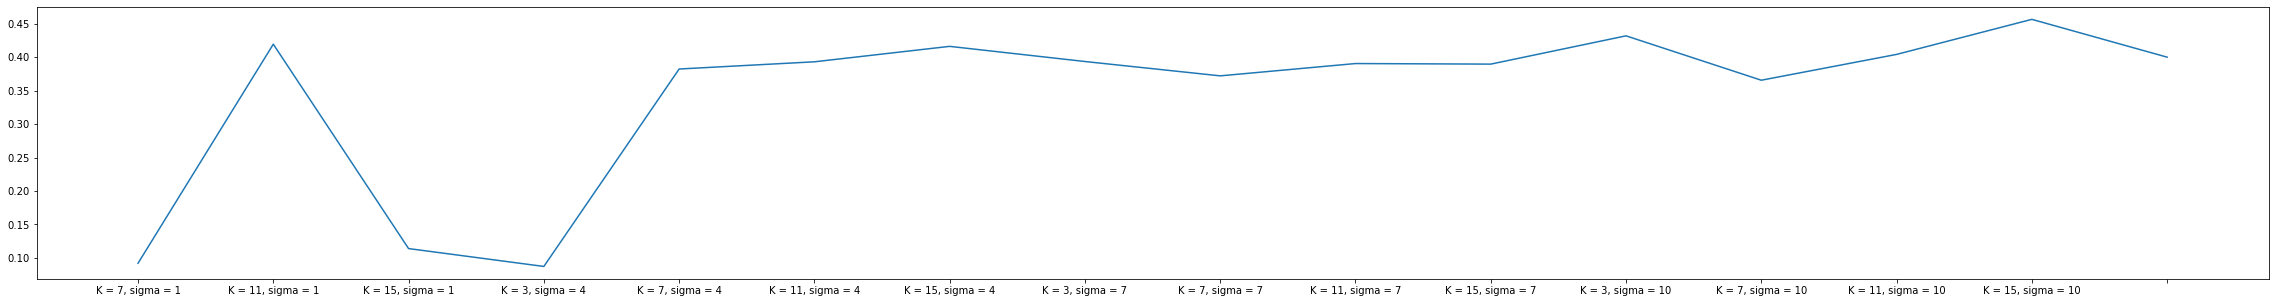

In [864]:
# Muestro las diferencias en la imagen del perro Cheems
fig = plt.figure(figsize = (40,5))
ax = fig.subplots()

ax.plot(df['Cheems_Diff'])
ax.set_xticklabels(row_names)
plt.locator_params(axis = 'x', nbins = 30)
plt.show()

Podemos ver que las diferencias porcentuales con muy bajas para la imagen de Chaplin, pero para la imagen del perro son más notorias. A continuación, vamos a probar otra métrica, la de Brenner.

In [865]:
# Ahora calculo la calidad de imagen para todas las combinaciones de Ks y Sigmas mostradas anteriormente.
ks = np.arange(3, 19, 4)
sigmas = np.arange(1, 11, 3)

chaplin_conv = np.array([])
chaplin_fourier = np.array([])
cheems_conv = np.array([])
cheems_fourier = np.array([])
row_names = np.array([])
K = np.array([])
S = np.array([])

for i in range(len(sigmas)):
    for j in range(len(ks)):
        kernel_gauss, kernel_fourier = create_gauss_filter(img.shape[0], img.shape[1], ks[j], sigmas[i])
        kernel_gauss_cheems, kernel_fourier_cheems = create_gauss_filter(cheems.shape[0], cheems.shape[1], ks[j], sigmas[i])
        
        row_name = 'K = ' + str(ks[j]) + ', sigma = ' + str(sigmas[i])
        row_names = np.append(row_names, [row_name])
        
        # Chaplin.
        img_conv = cv.GaussianBlur(img, ksize = (ks[j], ks[j]), sigmaX = sigmas[i])
        img_fft = np.fft.fft2(img)
        filtered = img_fft * kernel_fourier    
        img_fourier = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))
        
        # Perro Cheems.
        img_conv_cheems = cv.GaussianBlur(cheems, ksize = (ks[j], ks[j]), sigmaX = sigmas[i])
        img_fft_cheems = np.fft.fft2(cheems)
        filtered_cheems = img_fft_cheems * kernel_fourier_cheems    
        img_fourier_cheems = np.fft.ifftshift(np.real(np.fft.ifft2(filtered_cheems)))
        
        chaplin_conv = np.append(chaplin_conv, [Brenner(img_conv)])
        chaplin_fourier = np.append(chaplin_fourier, [Brenner(img_fourier)])
        cheems_conv = np.append(cheems_conv, [Brenner(img_conv_cheems)])
        cheems_fourier = np.append(cheems_fourier, [Brenner(img_fourier_cheems)])
        K = np.append(K, [ks[j]])
        S = np.append(S, [sigmas[i]])


dif_Chaplin =  abs(chaplin_conv - chaplin_fourier)/chaplin_conv
dif_Cheems =  abs(cheems_conv - cheems_fourier)/cheems_conv
df = pd.DataFrame({'K': K,
                   'Sigma': S,
                   'Chaplin_C': chaplin_conv,
                   'Chaplin_F': chaplin_fourier,
                   'Chaplin_Diff': dif_Chaplin,
                   'Cheems_C': cheems_conv,
                   'Cheems_F': cheems_fourier,
                   'Cheems_Diff': dif_Cheems})

In [866]:
df

,K,Sigma,Chaplin_C,Chaplin_F,Chaplin_Diff,Cheems_C,Cheems_F,Cheems_Diff
0,3.0,1.0,1.558894e+09,1.562849e+09,0.002537,21351680.0,2.131252e+07,0.001834
1,7.0,1.0,1.064943e+09,1.071181e+09,0.005857,17264758.0,1.724704e+07,0.001027
2,11.0,1.0,1.064943e+09,1.069835e+09,0.004594,17264758.0,1.723356e+07,0.001807
3,15.0,1.0,1.064943e+09,1.069835e+09,0.004594,17264758.0,1.723356e+07,0.001807
4,3.0,4.0,1.356945e+09,1.356948e+09,0.000003,19668492.0,1.961410e+07,0.002765
5,7.0,4.0,1.022747e+08,1.022806e+08,0.000058,8936428.0,8.903581e+06,0.003676
6,11.0,4.0,2.064842e+07,2.127760e+07,0.030471,5995304.0,5.994193e+06,0.000185
7,15.0,4.0,9.982296e+06,1.146239e+07,0.148271,4880428.0,4.874571e+06,0.001200
8,3.0,7.0,1.345526e+09,1.349883e+09,0.003238,19566698.0,1.955030e+07,0.000838
9,7.0,7.0,7.728612e+07,7.981115e+07,0.032671,8632322.0,8.625813e+06,0.000754


C:\Users\Leandro\AppData\Local\Temp/ipykernel_22184/1522027445.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(row_names)


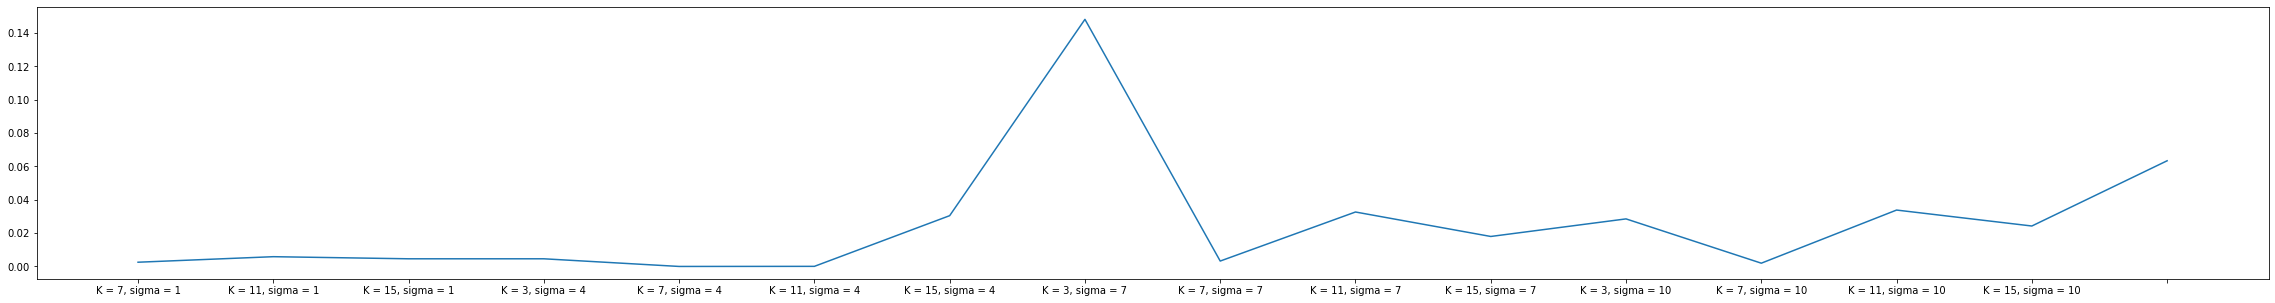

In [867]:
# Muestro las diferencias en la imagen de Chaplin.
fig = plt.figure(figsize = (40,5))
ax = fig.subplots()

ax.plot(df['Chaplin_Diff'])
ax.set_xticklabels(row_names)
plt.locator_params(axis = 'x', nbins = 30)
plt.show()

C:\Users\Leandro\AppData\Local\Temp/ipykernel_22184/294649494.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(row_names)


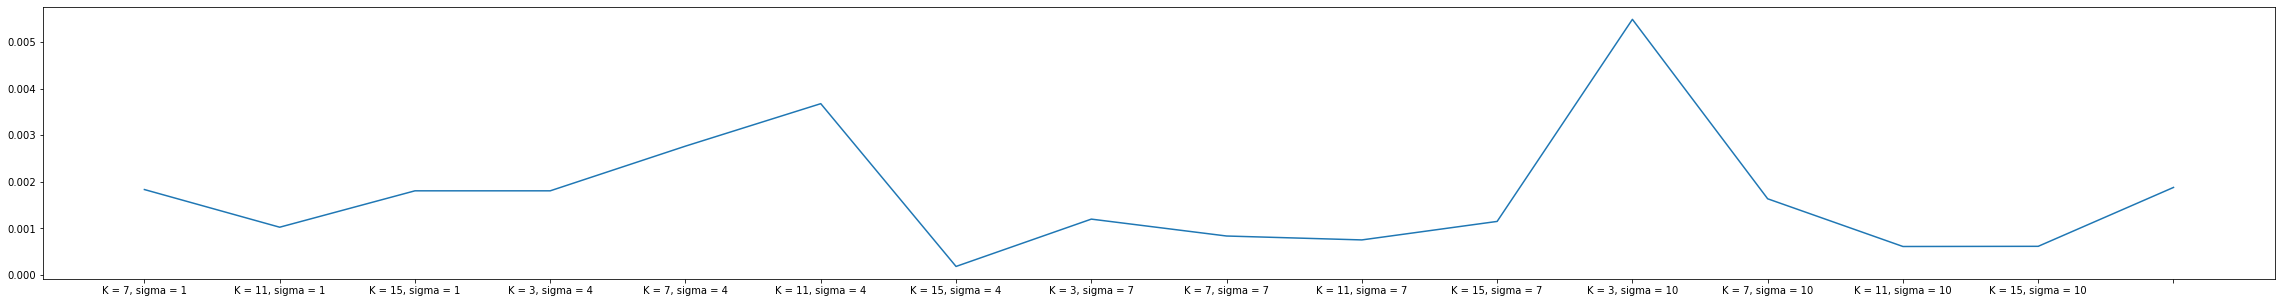

In [868]:
# Muestro las diferencias en la imagen del perro Cheems
fig = plt.figure(figsize = (40,5))
ax = fig.subplots()

ax.plot(df['Cheems_Diff'])
ax.set_xticklabels(row_names)
plt.locator_params(axis = 'x', nbins = 30)
plt.show()

Utilizando ahora la medición de Brenner, podemos ver cómo las diferencias siguen siendo muy pequeñas entre ambas imágenes (filtro convolucional y fourier), pero en este caso para las imágenes del perro las diferencias fueron muchísimo menores.